In [1]:
import os
from utils.dataset import SpectrogramsDataset
from utils.preprocessing import transform
from torch.utils.data import random_split
from torch import Generator

#split dataset deterministically
spec_dir = os.path.join('data', 'spec')
features_path = os.path.join('data', 'features.csv')
dataset = SpectrogramsDataset(spec_dir, features_path, transform, target='danceability')
trainset, valset, testset = random_split(dataset, [0.07, 0.07, 0.86], Generator().manual_seed(42)) #TODO 0.8,0.1,0.1
len(trainset), len(valset), len(testset)

(67, 66, 815)

In [2]:
from torch.utils.data import DataLoader

#configure batches
kwargs = {
    'batch_size': 32, #TODO tune with Neptune
    'num_workers': 2,
    'pin_memory': True,
    'drop_last': True}
train_loader = DataLoader(trainset, shuffle=True, persistent_workers=True, **kwargs)
val_loader = DataLoader(valset, persistent_workers=True, **kwargs)
test_loader = DataLoader(testset, **kwargs)
_, channels, height, width = next(iter(train_loader))[0].shape
channels, height, width

(3, 224, 224)

In [3]:
import torch
from utils.models import DanceabilityModel
from torch import nn, optim

#configure training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DanceabilityModel(channels, height, width).to(device) #TODO tune with Neptune
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3) #TODO tune lr with Neptune
device

device(type='cpu')

In [4]:
from copy import deepcopy
from contextlib import suppress
import numpy as np

train_losses = []
val_losses = []
best_params = None
for epoch in range(999):

    #train
    model.train()
    running_loss = 0
    for inputs, labels in train_loader:
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device)) #estimates loss of batch with current parameters
        optimizer.zero_grad() #resets gradient to avoid accumulation
        loss.backward() #computes gradient of loss w.r.t. parameters
        optimizer.step() #updates parameters to reduce loss
        running_loss += loss.item()
    train_losses.append(running_loss/len(train_loader))
    print(f'[epoch {epoch:03}] train loss: {train_losses[-1]:.4f}, ', end='')

    #evaluate on validation set
    model.eval()
    running_loss = 0
    with torch.inference_mode(): #to save memory and computations
        for inputs, labels in val_loader:
            outputs = model(inputs.to(device))
            running_loss += criterion(outputs, labels.to(device)).item()
    val_losses.append(running_loss/len(val_loader))

    #back up best parameters
    end = '\n'
    if val_losses[-1] <= min(val_losses):
        best_params = deepcopy(model.state_dict())
        end = ' (new best)\n'
    print(f'val loss: {val_losses[-1]:.4f}', end=end)

    #stop early
    patience = 3
    with suppress(IndexError):
        if all(np.array(val_losses[-patience:]) > val_losses[-patience-1]):
            break

[epoch 000] train loss: 0.0407, val loss: 0.0403 (new best)
[epoch 001] train loss: 0.0379, val loss: 0.0335 (new best)
[epoch 002] train loss: 0.0336, val loss: 0.0315 (new best)
[epoch 003] train loss: 0.0293, val loss: 0.0308 (new best)
[epoch 004] train loss: 0.0278, val loss: 0.0307 (new best)
[epoch 005] train loss: 0.0238, val loss: 0.0302 (new best)
[epoch 006] train loss: 0.0318, val loss: 0.0296 (new best)
[epoch 007] train loss: 0.0282, val loss: 0.0284 (new best)
[epoch 008] train loss: 0.0263, val loss: 0.0277 (new best)
[epoch 009] train loss: 0.0253, val loss: 0.0274 (new best)
[epoch 010] train loss: 0.0247, val loss: 0.0263 (new best)
[epoch 011] train loss: 0.0218, val loss: 0.0250 (new best)
[epoch 012] train loss: 0.0222, val loss: 0.0263
[epoch 013] train loss: 0.0204, val loss: 0.0237 (new best)
[epoch 014] train loss: 0.0273, val loss: 0.0249
[epoch 015] train loss: 0.0202, val loss: 0.0264
[epoch 016] train loss: 0.0181, val loss: 0.0265


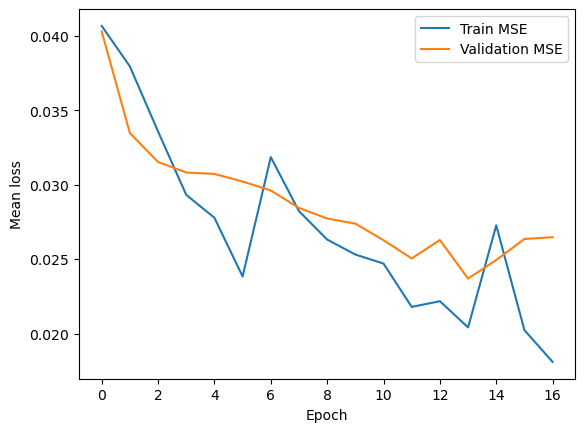

In [5]:
import matplotlib.pyplot as plt

#plot training history
labels = {'t': 'Train MSE', 'v': 'Validation MSE'} if isinstance(criterion, nn.MSELoss) else None
plt.plot(train_losses, label=labels['t'])
plt.plot(val_losses, label=labels['v'])
plt.legend()
plt.xlabel('Epoch')
_ = plt.ylabel('Mean loss')

In [6]:
import torch.nn.functional as F

#evaluate on test set
model.load_state_dict(best_params)
assert not model.training
running_loss = 0
with torch.inference_mode():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(device))
        running_loss += F.l1_loss(outputs, labels.to(device)).item() #MAE for interpretability
print(f'Mean absolute error on test set: {running_loss/len(test_loader):.4f}')

Mean absolute error on test set: 0.1317


In [7]:
#save best parameters
param_dir = os.path.join('utils', 'model_params')
os.makedirs(param_dir, exist_ok=True)
param_path = os.path.join(param_dir, 'danceability.pth')
torch.save(best_params, param_path)

# TODO
* fai usage example dove istanzi modello e ottieni output (sistema e continua quello sotto)
* poi testa anche su colab con gpu (e vedi se serve [questo](https://pytorch.org/tutorials/recipes/recipes/save_load_across_devices.html))

In [8]:
#load model (as usage example, to restore best parameters and to have it on CPU)
model = DanceabilityModel(channels, height, width)
model.eval() #disable training mode
model.load_state_dict(torch.load(param_path))

<All keys matched successfully>